# Convolutional Neural Networks

## Designing and training a CNN from scratch

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## Data

#### Procedure for Image Processing

My code first resizes the image to 256 pixels while keeping the aspect ratio. It then applies a random crop of size 224 pixels using the `transforms.RandomCrop(224)` to obtain a fixed input size for the model. The dataset is then augmented using several techniques. Images are rotated, translated, and shear is applied to increase the robustness of the model to different points of views and orientations of the objects in the images. The image is then horizontally flipped with a probability of 0.5 which helps to reduce overfitting.

#### Visualize a Batch of Training Data

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


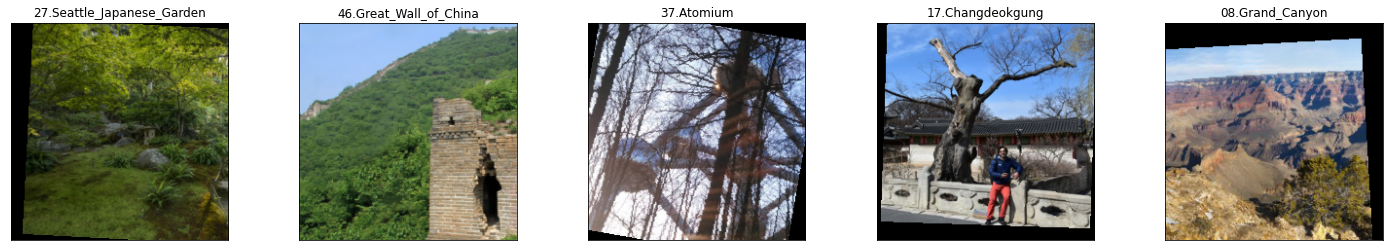

In [3]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary
batch_size = 5
validation_size = 0.01
num_workers = -1

data_loaders = get_data_loaders(batch_size, validation_size, num_workers)# YOUR CODE HERE

visualize_one_batch(data_loaders)

## Define Model

#### CNN Architecture

My CNN architecture has four convolutional layers, each followed by a max pooling layer, and two fully connected layers. The output of the final fully connected layer is of size `num_classes`, which is the number of different landmarks we want to classify. A dropout layer is inserted after the first fully connected layer to reduce overfitting.

## Define loss and optimizer


## Train and Validate the Model

In [13]:
batch_size = 32        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.3       # fraction of the training data to reserve for validation
num_epochs = 60        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.6          # dropout for our model
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.05     # regularization. Increase this to combat overfitting

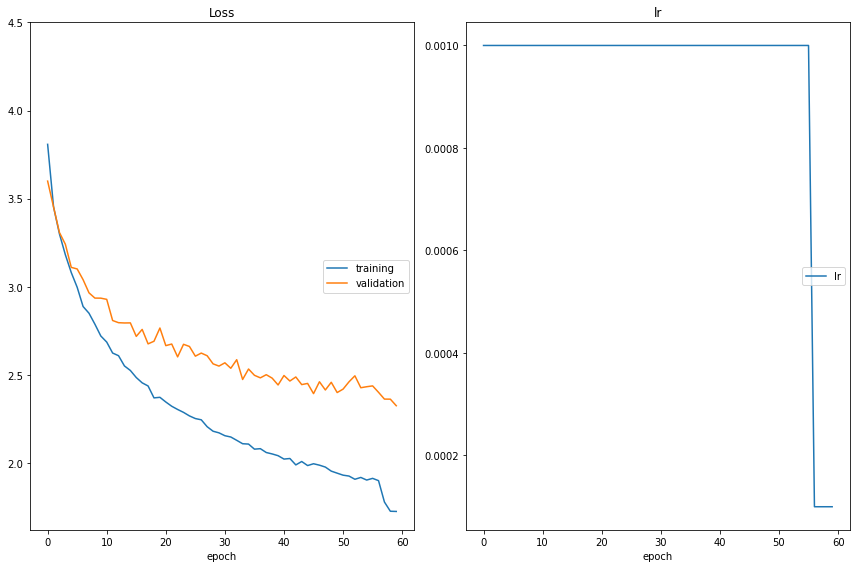

In [14]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined 
data_loaders = get_data_loaders()

# instance model MyModel with num_classes and drouput defined 
model = MyModel(num_classes = num_classes, dropout = dropout)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified 
optimizer = get_optimizer(model, opt, learning_rate= learning_rate, weight_decay = weight_decay)# YOUR CODE HERE

# Get the loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

## Testing against the Test Set

In [15]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:08<00:00,  4.83it/s]

Test Loss: 2.062723


Test Accuracy: 51% (643/1250)


2.0627231582999235

## Export using torchscript

Allright, now we are ready to export our model using our Predictor class:

In [17]:
# restart your notebook then execute only this cell if an error occurs
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# get the class names from data loaders
class_names = data_loaders["train"].dataset.classes

# move the model to the CPU (don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Loading mode with best weights
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt', map_location = 'cpu'))

# wrap model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [18]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("checkpoints/original_exported.pt") 

In [19]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [02:40<00:00,  7.77it/s]

Accuracy: 0.4632


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

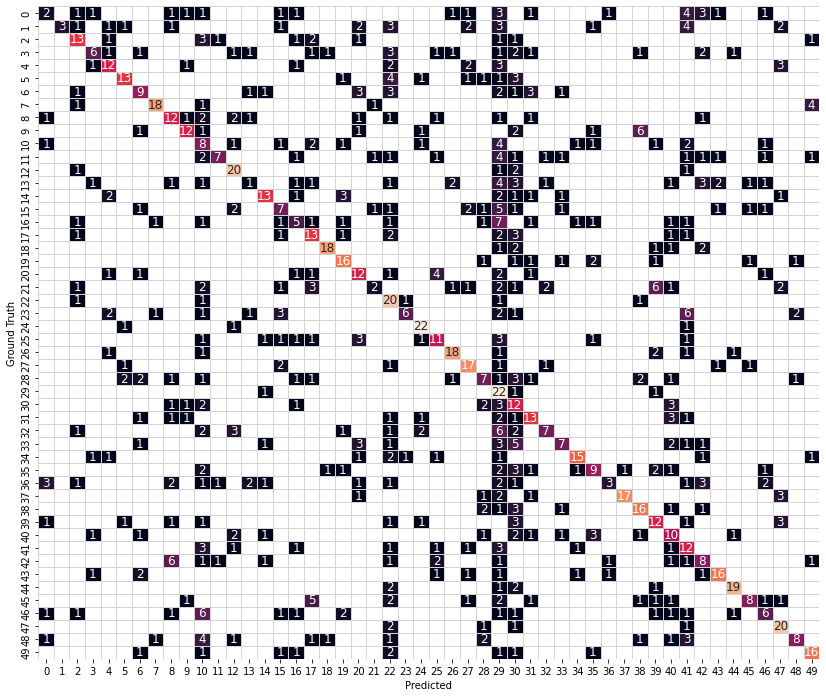

In [20]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)